# Dataset
Test environment for constructing a fast `tensorflow.data.Dataset`.

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.data import Dataset

In [2]:
import os
from dmv.data import mura_meta, _benchmark

data_folder = r'C:\Users\jeroe\data\MURA\MURA-v1.1\small'

df_train = mura_meta(os.path.join(data_folder, 'MURA-v1.1', 'train_image_paths.csv'))
df_valid = mura_meta(os.path.join(data_folder, 'MURA-v1.1', 'valid_image_paths.csv'))

df_train_small = df_train.head(500)

In [32]:
import math

def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.resize_with_crop_or_pad(img, 128, 128)
    img = tf.image.convert_image_dtype(img, dtype=tf.float16)
    
    return img

def mura_dataset(root, df, augmentation=None, multi=False, batch_size=8):
    # Since we use a buffered sample, it makes sense to first shuffle the entire dataset
    df = df.sample(frac=1)
    
    if multi:
        output_shape = [None]
    else:
        output_shape = []
        df = df.explode('file')
        
    def gen():
        for index, row in df.iterrows():
            if multi:
                img = tf.stack([os.path.join(root, row['folder'], img_file) for img_file in row['file']])
            else:
                img = os.path.join(root, row['folder'], row['file'])
            
            yield(img, row['label'])

    ds = Dataset.from_generator(
        gen,
        (tf.string, tf.int16),
        (tf.TensorShape(output_shape), tf.TensorShape([]))
    )
    
    def decode(paths, label):
        if multi:
            imgs = tf.map_fn(decode_img, paths, fn_output_signature=tf.TensorSpec([128, 128, 1], dtype=tf.float16))
        else:
            imgs = decode_img(paths)
        return imgs, label
    
    ds = ds.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
    
    # Apply the augmentation if an augmentation function is provided
    if augmentation is not None:
        def tf_augmentation(images, label):
            images_shape = images.shape
            [image, ] = tf.py_function(augmentation, [image], [tf.float16])
            image.set_shape(images_shape)
            return image, label
        
        ds = ds.map(tf_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # A buffer of approximately one fifth the dataset? guestimate
    ds = ds \
        .shuffle(buffer_size=df.shape[0] // 5) \
        .padded_batch(batch_size) \
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
    return math.ceil(df.shape[0] / batch_size), ds

In [33]:
steps_per_epoch, ds_train = mura_dataset(data_folder, df_train, multi=False)

In [34]:
_benchmark(ds_train, num_epochs=3, sleep=0.0)

Execution time: 4.993931633333318


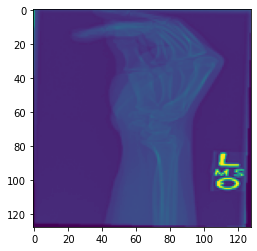

In [38]:
import matplotlib.pyplot as plt

n = next(iter(ds_train))
plt.imshow((n[0][0].numpy() * 255).astype(int))